In [ ]:
import pandas as pd
import scanpy as sc

import anndata as ad
from sklearn.preprocessing import StandardScaler

import utils as ut

INPUT_DIR = "./data/raw/mrd"
OUTPUT_DIR = "./data/output/"

# Step 1: Load the CSV file
# df = pd.read_csv("8_SN141_slides2_ROI-03.csv")

import os

feature_files = []
region_list = []
for path, subdirs, files in os.walk(INPUT_DIR):
    for name in files:
        fname, ext = os.path.splitext(name)
        if ext == ".csv":
            rel_path = os.path.relpath(path, INPUT_DIR)
            feature_files.append(os.path.join(rel_path, name))
            region_list.append(os.path.join(rel_path, fname))
print(feature_files)
print(region_list)

df = ut.combine_feature_files(
    INPUT_DIR,
    feature_files,
    region_list
    )


In [ ]:
# 1.b clean column names
import re
df.columns = df.columns.str.replace('Biomarker Exp', '', regex=False).str.strip()

In [ ]:
# Step 2: Separate features and metadata
meta_column_names = ["Cell Id","Nuc X","Nuc Y Inv", "region_num", "unique_region"]
# meta_column_names = ["Cell Id","Nuc X","Nuc Y Inv"]
feature_cols = df.columns.difference(meta_column_names)
selected_features = [
"Arginase 1 REAL1137",
"CD11b REA1321",
"CD11c REA1310",
"CD14 REA1314",
"CD15 VIMC6",
"CD16 REA1324",
"CD163 REA1309",
"CD20 REAL1069",
"CD235a REA175",
"CD3 REAL1097",
"CD31 REA1312",
"CD34 REAL1217",
"CD38 REAL719",
"CD4 REA1307",
"CD45 5B1",
"CD68 REAL1346",
"CD73 REAL1172",
"CD79a REA1168",
"CD8a REA1024",
"FoxP3 REA1253",
"HLA DR REAL550",
"Ki 67 REAL1047",
"Mast Cell Tryptase REAL798",
"PAX 5 REA140",
"Podoplanin REA446",
]
unselected_features = feature_cols.difference(selected_features)
unselected_feat_exp = df[unselected_features].copy()
selected_feat_exp = df[selected_features].copy()
metadata = df[df.columns.difference(selected_features)].copy()

In [ ]:
selected_feat_exp

In [ ]:
metadata

In [ ]:
# Step 3: Normalize and scale features
def double_z_norm(data):
    scaler = StandardScaler()
    step1 = scaler.fit_transform(data)

    # Then z-score across samples (rows)
    scaler2 = StandardScaler()
    normalised_data = scaler2.fit_transform(step1.T).T
    return normalised_data

scaled_features = double_z_norm(selected_feat_exp)
scaled_unselected_features = double_z_norm(unselected_feat_exp)


In [ ]:
# Step 4: Create an AnnData object
adata = ad.AnnData(X=scaled_features)
adata.obs = metadata


In [ ]:
# Step 4: Compute PCA
sc.tl.pca(adata, svd_solver='arpack')


In [ ]:

# Step 5: Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)


In [ ]:

# Step 6: Apply Leiden clustering
sc.tl.leiden(adata, resolution=1.0)


In [ ]:

# Step 7: Inspect cluster assignments
print(adata.obs['leiden'].value_counts())


In [ ]:
adata

In [ ]:
expr_data = adata.raw.X if adata.raw is not None else adata.X
gene_names = adata.raw.var_names if adata.raw is not None else adata.var_names

# Convert to DataFrame for easier handling
expr_df = pd.DataFrame(expr_data, columns=selected_features)
unselected_df = pd.DataFrame(double_z_norm(adata.obs[unselected_features]), columns=unselected_features)
expr_df = pd.concat([expr_df, unselected_df], axis=1)
expr_df['leiden'] = adata.obs['leiden'].values

# Select marker genes

# replace with your markers
marker_expr = expr_df[list(selected_features) + list(unselected_features) + ['leiden']]

# Compute mean expression per cluster
cluster_means = marker_expr.groupby('leiden').mean()

print(cluster_means)


In [ ]:
custom_labels = {
    0: "Mixed Lymphoid",
    1: "Dendritic cell", 
    2: "Granulocyte",
    3: "Myeloid",
    4: "Erythroid", 
    5: "Monocytes/Macrophages", 
    6: "CD8 T Cell", 
    7: "Erythroid", 
    8: "Macrophage", 
    9: "Lymphoid", 
    10: "Granulocyte",
    11: "Unspecific", 
    12: "Unspecific", 
    13: "Early Lymphoid", 
    14: "Mesenchymal", 
    15: "Monocytes", 
    16: "Early B", 
    17: "Endothelial cell", 
    18: "Plasma cell", 
    19: "T Cells", 
    20: "CD4 T cell", 
    21: "Dendritic cell", 
    22: "Mature B", 
    23: "Early B",
    24: "Plasma cell",
    25: "Endothelial cell", 
    26: "Endothelial cell", 
    27: "Endothelial cell", 
    28: "Mast cell", 
    29: "Megakaryocyte"}

In [ ]:

cluster_means.index = cluster_means.index.map(lambda x: str(x) + ":" + custom_labels.get(int(x), "Unspecified"))


In [ ]:
cluster_means

In [ ]:
# Now: x = clusters, y = markers
x_labels = cluster_means.index.tolist()  # clusters
y_labels = list(selected_features)  # markers
y_labels_all = list(selected_features) + list(unselected_features)  # markers

In [ ]:
x_labels

In [138]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

def plot_dotplot(cluster_means, x_labels, y_labels, save_path="dotplot.png", title="Mean Marker Expression per Cluster"):
    """
    Create a dot plot heatmap showing mean marker expression per cluster.
    
    Parameters:
    -----------
    cluster_means : pd.DataFrame
        DataFrame with clusters as rows and markers as columns
    x_labels : list
        List of cluster labels for x-axis
    y_labels : list
        List of marker labels for y-axis
    save_path : str
        Path to save the figure (default: "dotplot.png")
    title : str
        Title for the plot (default: "Mean Marker Expression per Cluster")
    """
    # Scale figure height to number of markers
    fig_height = max(6, len(y_labels) * 0.15)
    fig, ax = plt.subplots(figsize=(len(x_labels) * 0.2, fig_height))

    # Normalize values for consistent color mapping
    vmax = cluster_means.values.max()
    vmin = cluster_means.values.min()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.cm.RdYlBu_r

    for x_idx, cluster in enumerate(x_labels):
        for y_idx, gene in enumerate(y_labels):
            val = cluster_means.loc[cluster, gene]
            safe_val = max(val, 0.001) if not np.isnan(val) else 0.001
            dot_size = np.sqrt(safe_val) * 40  # adjust scale factor

            ax.scatter(
                x_idx, y_idx,
                s=dot_size,
                color=cmap(norm(val)),
                edgecolors='grey',
                linewidth=0.5
            )

    # Formatting
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=6)

    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels, fontsize=6)

    ax.set_xlim(-0.5, len(x_labels) - 0.5)
    ax.set_ylim(-0.5, len(y_labels) - 0.5)

    ax.set_title(title, fontsize=8)

    # Add colorbar with moderate size
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.05, pad=0.04, shrink=0.6)
    cbar.set_label("Mean Expression", fontsize=8)

    ax.grid(False)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    
    return fig, ax

def plot_heatmap(cluster_means, x_labels, y_labels, save_path="heatmap.png", title="Mean Marker Expression per Cluster"):
    """
    Create a heatmap showing mean marker expression per cluster.
    
    Parameters:
    -----------
    cluster_means : pd.DataFrame
        DataFrame with clusters as rows and markers as columns
    x_labels : list
        List of cluster labels for x-axis
    y_labels : list
        List of marker labels for y-axis
    save_path : str
        Path to save the figure (default: "heatmap.png")
    title : str
        Title for the plot (default: "Mean Marker Expression per Cluster")
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    # Select only the specified markers from cluster_means
    data_subset = cluster_means[y_labels]
    
    # Transpose so rows = markers, columns = clusters
    data = data_subset.T  

    # Dynamic scaling for figure size and font size
    num_markers = len(y_labels)
    num_clusters = len(x_labels)
    
    # Scale figure size - cap height to prevent blow-up
    fig_width = max(8, num_clusters * 0.5)
    # Use logarithmic-like scaling for height to prevent excessive growth
    if num_markers <= 30:
        fig_height = max(6, num_markers * 0.2)
        y_fontsize = 6
    elif num_markers <= 100:
        fig_height = max(10, min(20, num_markers * 0.1))
        y_fontsize = 4
    else:
        fig_height = max(15, min(30, num_markers * 0.1))
        y_fontsize = 4

    fig = plt.figure(figsize=(fig_width, fig_height))

    sns.heatmap(
        data,
        cmap="RdYlBu_r",
        cbar_kws={'label': 'Mean Expression', 'shrink': 0.5},
        linewidths=0.3,
        linecolor='lightgrey',
        yticklabels=True  # Force all y-axis labels to be shown
    )

    plt.title(title, fontsize=8)
    plt.xlabel('Clusters', fontsize=8)
    plt.ylabel('Marker Genes', fontsize=8)

    # Rotate x-axis labels for readability
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=y_fontsize)
    
    # Ensure all y-axis labels are visible
    ax = plt.gca()
    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels, rotation=0, fontsize=y_fontsize)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    

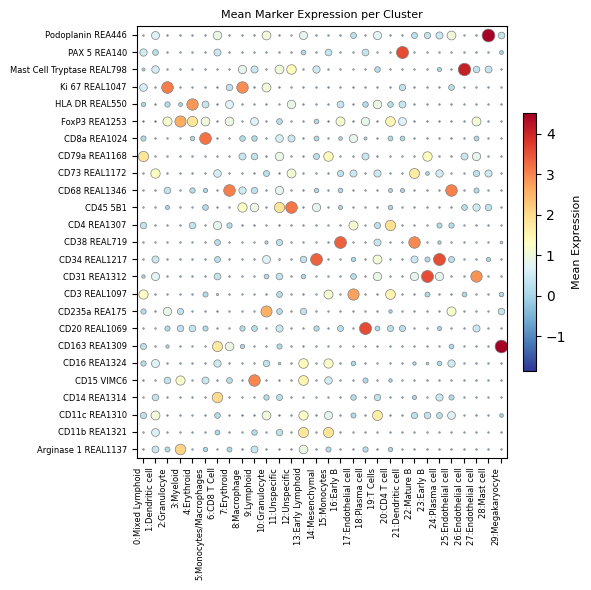

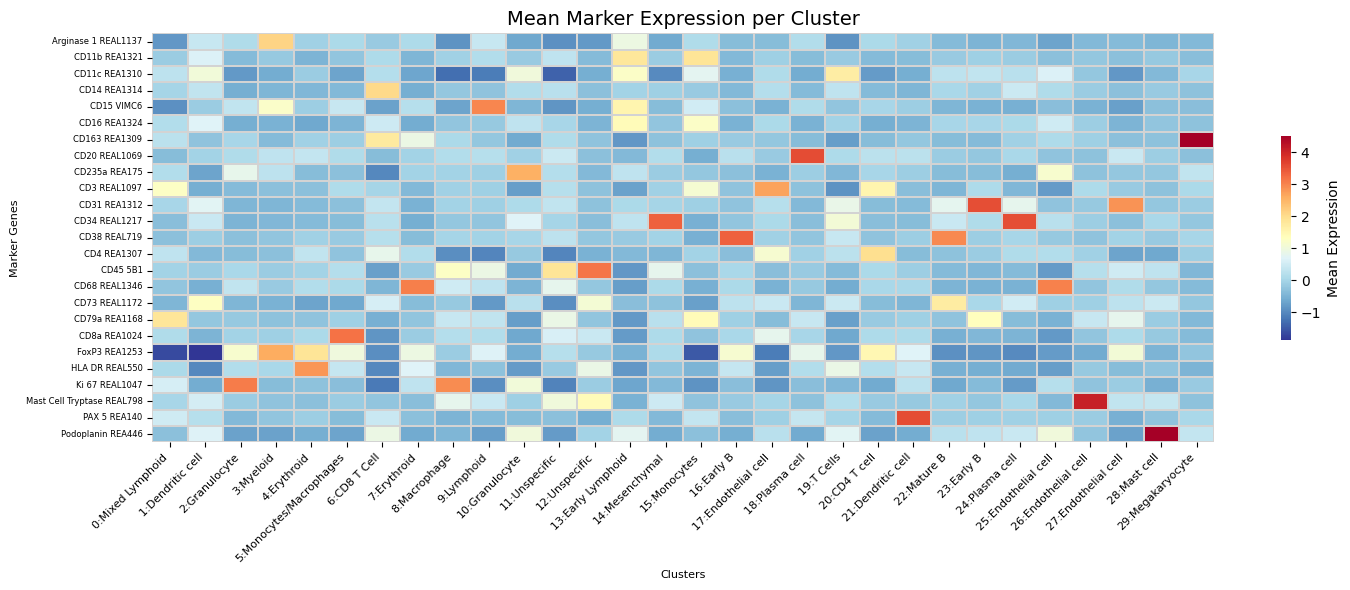

In [126]:
# Plot on raw clusters before pooling
plot_dotplot(cluster_means, x_labels, y_labels, save_path="dotplot.png")
plot_heatmap(cluster_means, x_labels, y_labels, save_path="heatmap.png")

In [127]:
# Pool clusters with the same name and use all markers
# Extract just the cell type names (removing the cluster index)
pooled_cluster_names = cluster_means.index.map(lambda x: x.split(':', 1)[1] if ':' in x else x)

# Create a temporary dataframe with the pooled names
temp_df = cluster_means.copy()
temp_df['pooled_cluster'] = pooled_cluster_names

# Group by the pooled cluster names and compute mean across all clusters with same name
pooled_cluster_means = temp_df.groupby('pooled_cluster').mean()

print(f"Original clusters: {len(cluster_means)}")
print(f"Pooled clusters: {len(pooled_cluster_means)}")
print(f"\nPooled cluster names:")
print(pooled_cluster_means.index.tolist())

Original clusters: 30
Pooled clusters: 21

Pooled cluster names:
['CD4 T cell', 'CD8 T Cell', 'Dendritic cell', 'Early B', 'Early Lymphoid', 'Endothelial cell', 'Erythroid', 'Granulocyte', 'Lymphoid', 'Macrophage', 'Mast cell', 'Mature B', 'Megakaryocyte', 'Mesenchymal', 'Mixed Lymphoid', 'Monocytes', 'Monocytes/Macrophages', 'Myeloid', 'Plasma cell', 'T Cells', 'Unspecific']


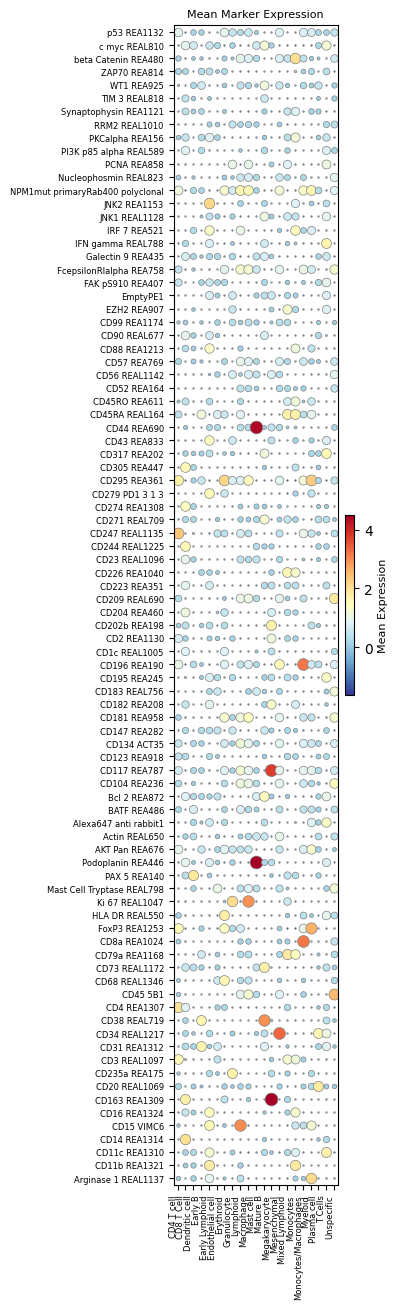

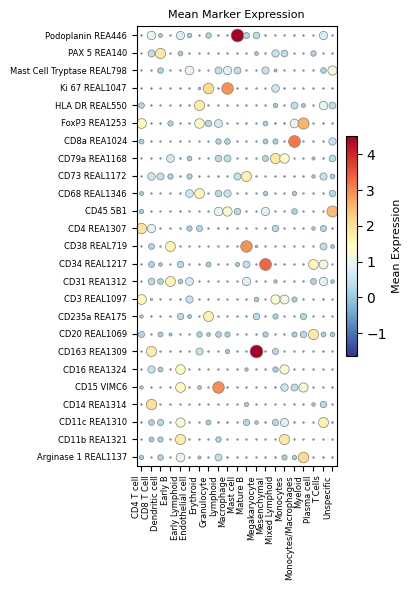

(<Figure size 420x600 with 2 Axes>,
 <Axes: title={'center': 'Mean Marker Expression'}>)

In [136]:
# Prepare labels for the pooled clusters with all markers
pooled_x_labels = pooled_cluster_means.index.tolist()  # pooled cluster names

# Generate dotplot with pooled clusters and all markers
plot_dotplot(
    pooled_cluster_means, 
    pooled_x_labels, 
    y_labels_all,
    save_path="dotplot_pooled_all_markers.png",
    title="Mean Marker Expression"
)

# Generate dotplot with pooled clusters and selected markers
plot_dotplot(
    pooled_cluster_means,
    pooled_x_labels,
    y_labels,
    save_path="dotplot_pooled_selected_markers.png",
    title="Mean Marker Expression" 
)

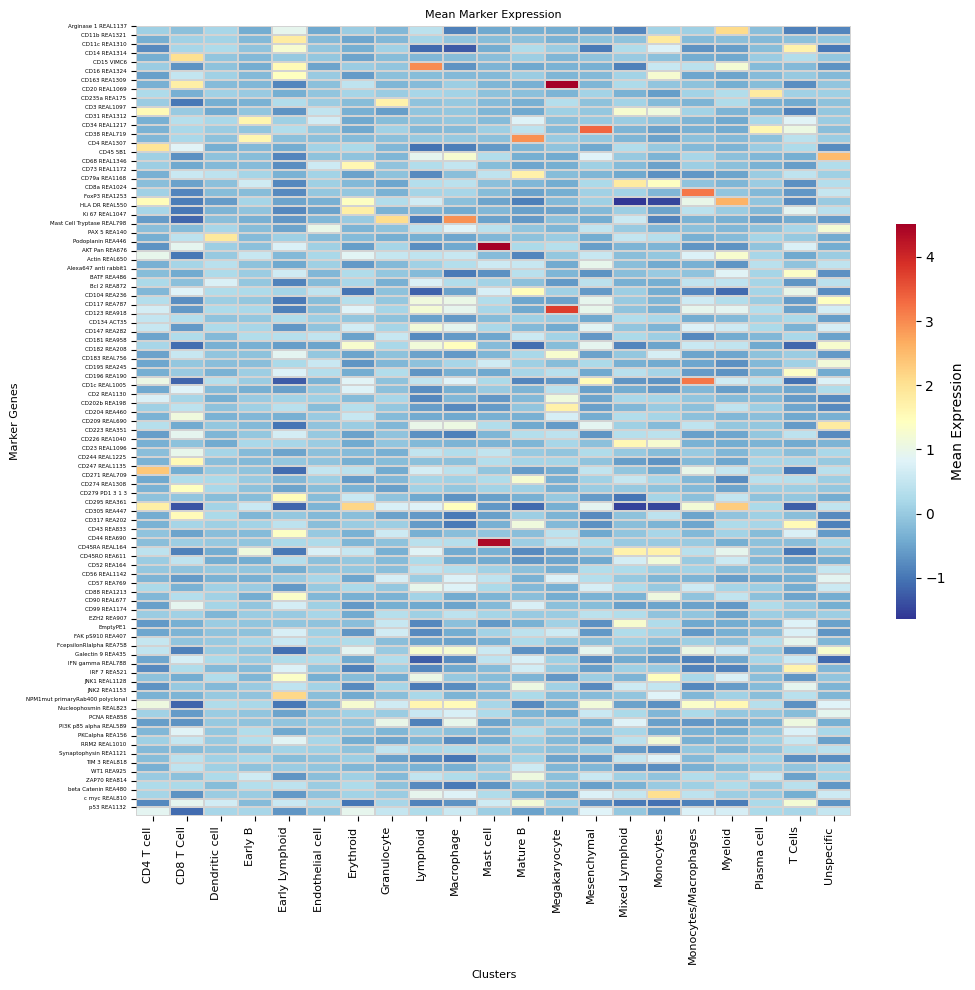

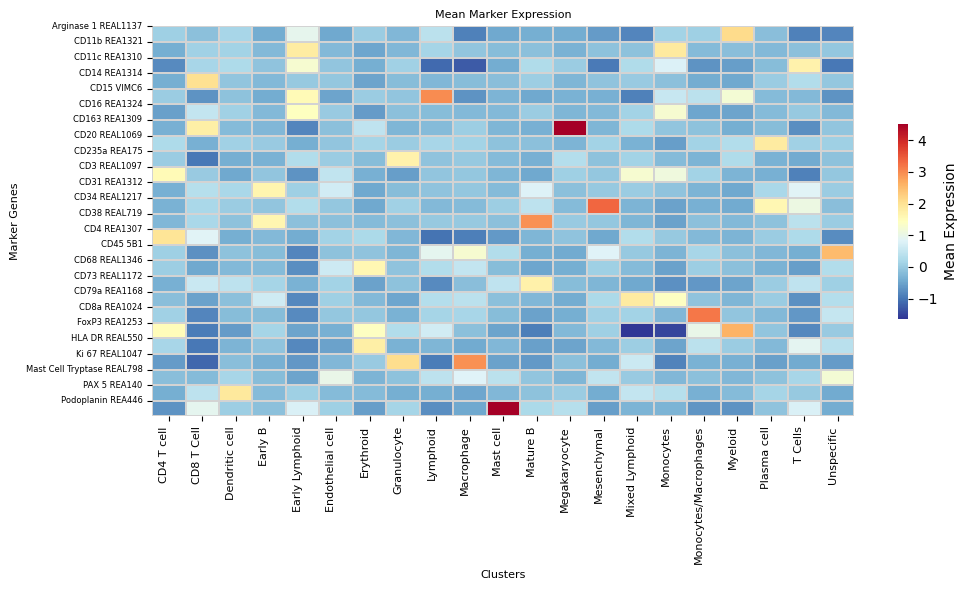

In [139]:
# Generate heatmap with pooled clusters and all markers
plot_heatmap(
    pooled_cluster_means, 
    pooled_x_labels,
    y_labels_all,
    save_path="heatmap_pooled_all_markers.png",
    title="Mean Marker Expression"
)

plot_heatmap(
    pooled_cluster_means, 
    pooled_x_labels,
    y_labels,
    save_path="heatmap_pooled_selected_markers.png",
    title="Mean Marker Expression"
)

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')

In [ ]:
# Top markers

# Run differential expression analysis
# sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')

# Convert to DataFrame
marker_df = sc.get.rank_genes_groups_df(adata, group=None)  # group=None gets all clusters

marker_df['names'] = marker_df['names'].apply(lambda x: selected_features[int(x)])
top_k = 5
top_markers = (
    marker_df
    .sort_values(['group', 'logfoldchanges'], ascending=[True, False])
    .groupby('group')
    .head(top_k)
)

top_markers.to_csv('top_markers_per_cluster.csv', index=False)

In [ ]:
top_markers

In [ ]:

# Optional: Save results
adata.obs.to_csv("cluster_assignments.csv", index=False)

In [ ]:
df.columns[df.isna().any()].tolist()

In [ ]:
# Split AnnData by 'sample' column
split_dict = {
    sample: adata[adata.obs['unique_region'] == sample].copy()
    for sample in adata.obs['unique_region'].unique()
}

In [ ]:
split_dict

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Compute UMAP embedding
sc.tl.umap(adata)

# Step 2: Plot UMAP colored by Leiden clusters
sc.pl.umap(adata, color='leiden', title='Leiden Clustering (UMAP)', palette='tab20', save=False)



In [ ]:
# Optional: Plot spatial coordinates colored by cluster
def plot_spatial_coordinates(adata, save_path):
    plt.figure(figsize=(7, 6))
    sns.scatterplot(
        x=adata.obs['Nuc X'],
        y=adata.obs['Nuc Y Inv'],
        hue=adata.obs['leiden'],
        palette='tab20',
        s=9,
        linewidth=-1 
    )
    plt.title('Spatial View of Leiden Clusters')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(title='Cluster', bbox_to_anchor=(0.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"{save_path}.png")
    plt.show()
    

for region_name, data in split_dict.items():
    print(f"Plot for region {region_name}")
    output_prefix = os.path.join(OUTPUT_DIR, region_name)
    plt_f = plot_spatial_coordinates(data, output_prefix)
    # data.obs.
    data.obs.to_csv(f"{output_prefix}_cluster_assignments.csv", index=False)